<a href="https://colab.research.google.com/github/NatashaKamami/Advanced_ML/blob/main/SpotifySentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the necessary libraries and loading the dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
# loading the dataset
df = pd.read_csv('/content/reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


### **Data Cleaning**

In [ ]:
df["Rating"].value_counts()

,count
Rating,
5,22095
1,17653
4,7842
2,7118
3,6886


In [ ]:
def transform_ratings(rating):
    if rating >= 4:  # Covers 4 and 5
        return "Good"
    elif rating == 3:
        return "Neutral"
    else:  # Covers 1 and 2
        return "Bad"

df['Rating'] = df['Rating'].apply(transform_ratings)

In [ ]:
df = df.head(30000)
data = pd. DataFrame(df[['Review', 'Rating']])
data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",Good
1,Please ignore previous negative rating. This a...,Good
2,"This pop-up ""Get the best Spotify experience o...",Good
3,Really buggy and terrible to use as of recently,Bad
4,Dear Spotify why do I get songs that I didn't ...,Bad


### **Text Preprocessing**

In [ ]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

#Function to clean the columns
def clean_text(text):

  #Convert text to lowercase
  text = text.lower()

  #Process text using spacy
  doc = nlp(text)

  #Lemmatization and removing stop words and punctuation
  cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

  return cleaned_text

In [ ]:
data['Review'] = data['Review'].apply(clean_text)
data.head()

,Review,Rating
0,great music service audio high quality app eas...,Good
1,ignore previous negative rating app super grea...,Good
2,pop good spotify experience android 12 annoyin...,Good
3,buggy terrible use recently,Bad
4,dear spotify song playlist shuffle play,Bad


### **Visualizations**

In [ ]:
#Creating a word cloud
from wordcloud import WordCloud
text = ' '.join(data['Review'])

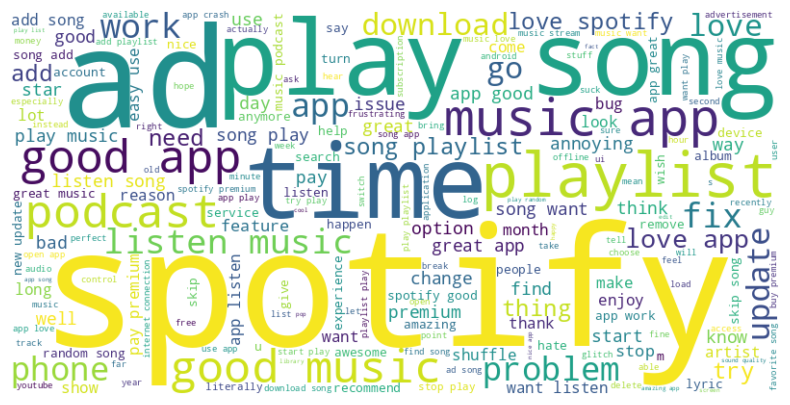

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

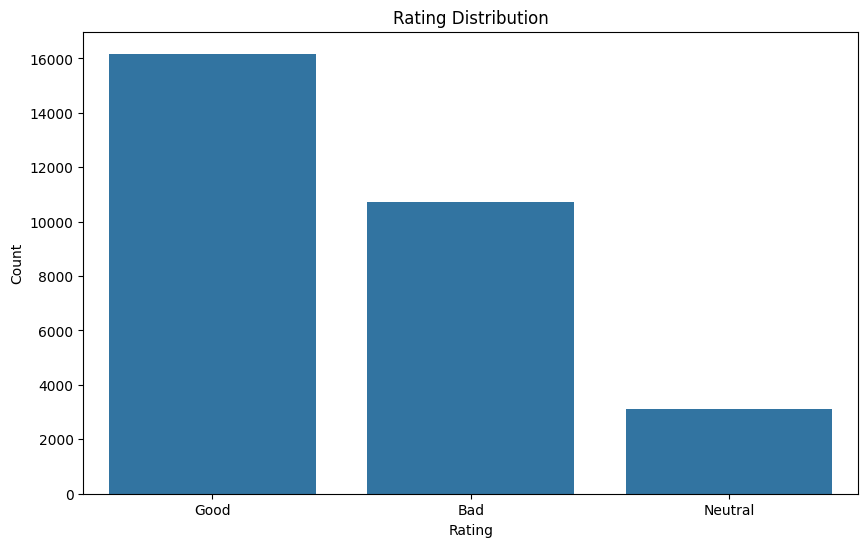

In [ ]:
# Bar graph to show the count of different values in the rating column
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### **Splitting the dataset**

In [ ]:
X = data['Review']
y = data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000,), (9000,), (21000,), (9000,))

### **Feature Extraction**

In [ ]:
# Using TFIDF
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [ ]:
# Using count vectorizer
# vectorizer = CountVectorizer()
# X_train_transformed = vectorizer.fit_transform(X_train)
# X_test_transformed = vectorizer.transform(X_test)

# Gives an f1 score of 0.71 in both logistic regression andrandom forest

### **Handling data imbalance**

In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

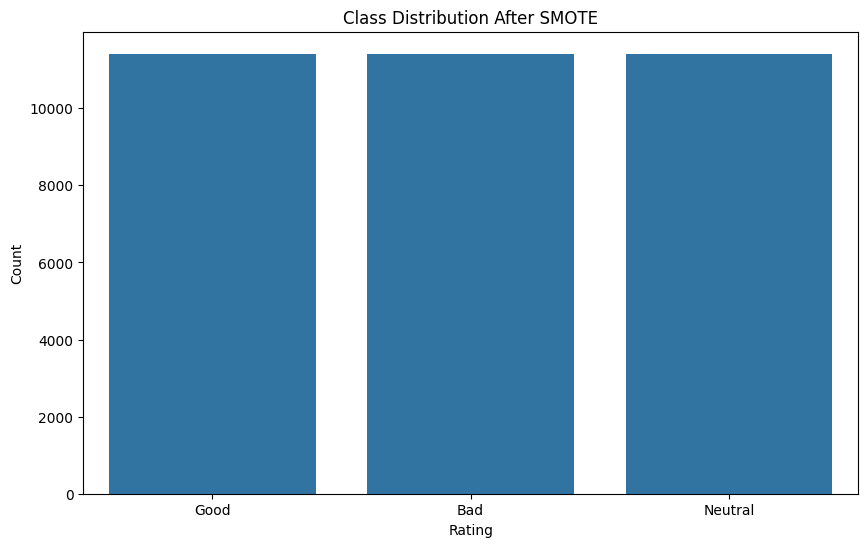

In [ ]:
# Visualizing the balanced rating column
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## **Modelling**

### **1. Logistic Regression**

In [ ]:
# Create and train the Logistic Regression model
log_model = LogisticRegression( max_iter=1000, random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = log_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

         Bad       0.75      0.69      0.72      3278
        Good       0.89      0.79      0.84      4758
     Neutral       0.22      0.39      0.28       964

    accuracy                           0.71      9000
   macro avg       0.62      0.63      0.61      9000
weighted avg       0.77      0.71      0.73      9000

0.7345340253641299


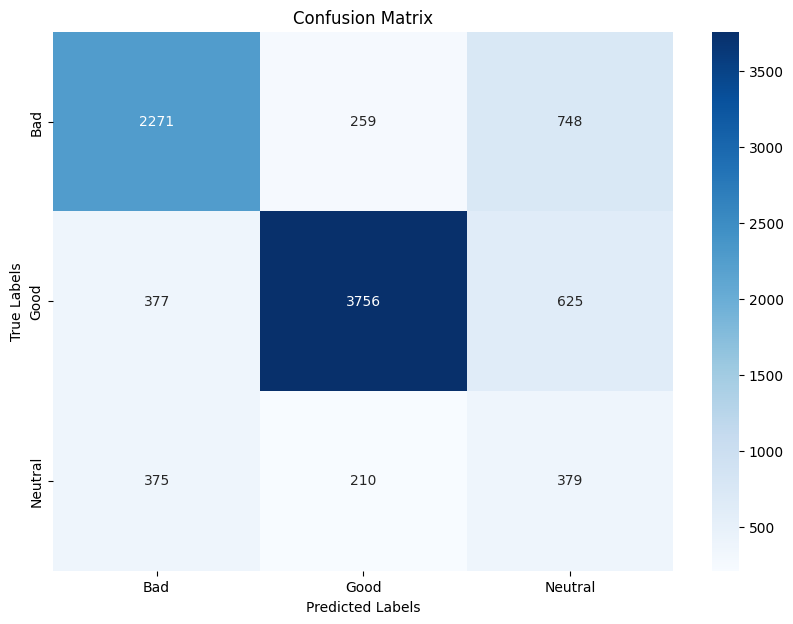

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### **2. Support Vector Classification**

In [ ]:
# Create and train the SVM model
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = svc_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

         Bad       0.73      0.68      0.71      3278
        Good       0.90      0.77      0.83      4758
     Neutral       0.21      0.40      0.27       964

    accuracy                           0.70      9000
   macro avg       0.61      0.62      0.60      9000
weighted avg       0.76      0.70      0.73      9000

0.7255357005575642


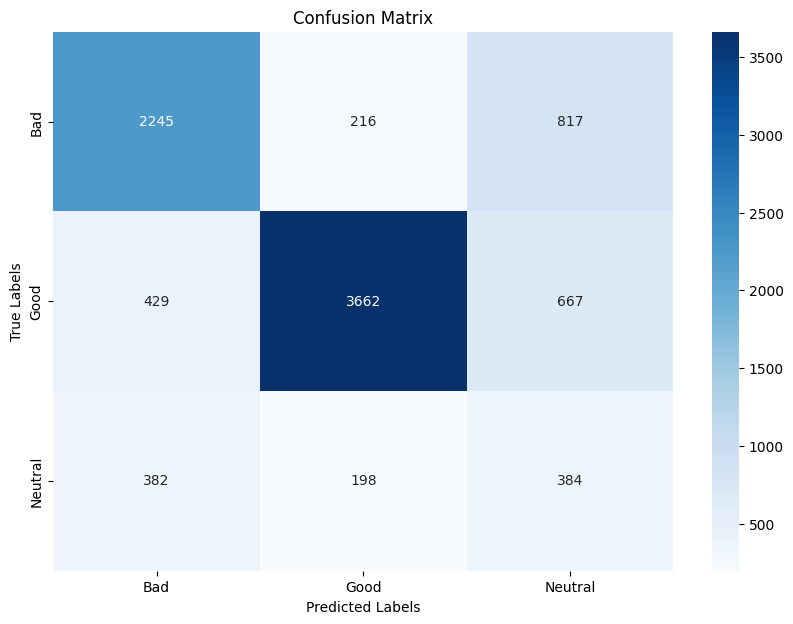

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svc_model.classes_, yticklabels=svc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### **3. Random Forest Classifier**

In [ ]:
# Create and train the random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = rf_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

         Bad       0.70      0.83      0.76      3278
        Good       0.84      0.85      0.85      4758
     Neutral       0.22      0.06      0.09       964

    accuracy                           0.76      9000
   macro avg       0.59      0.58      0.57      9000
weighted avg       0.72      0.76      0.73      9000

0.7334633032765834


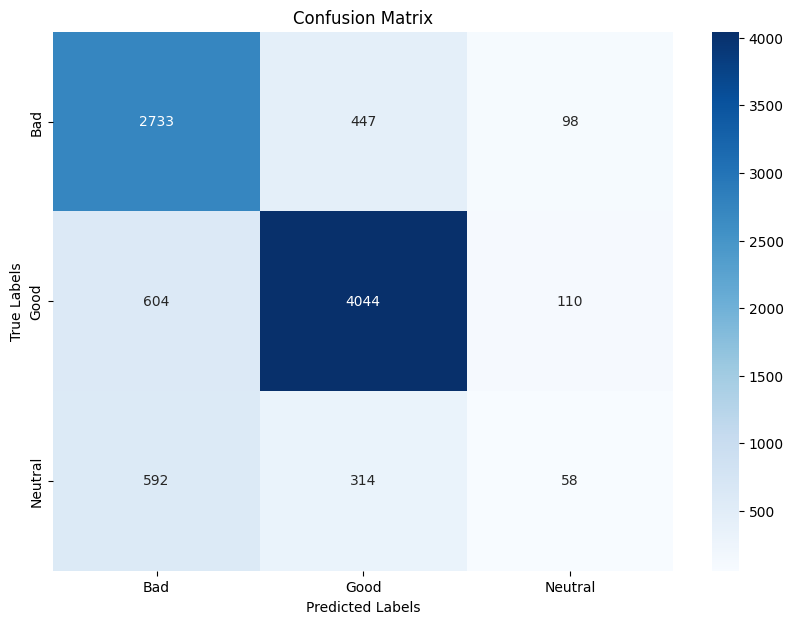

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### **Predictions on example reviews**

In [ ]:
# Example reviews
new_reviews = [
    "This app is so great!",
    "My Spotify is always lagging. Horrible experience.",
    "Works just fine but the ads are annoying."
]

# Process and predict sentiment for each review using logistic regression since it had the highest f1 score
for review in new_reviews:
    # Clean the review
    cleaned_review = clean_text(review)
    # Vectorize the cleaned review
    vectorized_review = vectorizer.transform([cleaned_review])
    # Make a prediction
    prediction = log_model.predict(vectorized_review)
    # Print the review and its prediction
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {prediction[0]}")
    print("-" * 50)


Review: This app is so great!
Predicted Sentiment: Good
--------------------------------------------------
Review: My Spotify is always lagging. Horrible experience.
Predicted Sentiment: Bad
--------------------------------------------------
Review: Works just fine but the ads are annoying.
Predicted Sentiment: Neutral
--------------------------------------------------


Logistic Regression and SVM tend to perform better with high-dimensional, sparse data (like text data) when compared to Random Forest. They are also more robust to class imbalance. Since the test data used is imbalanced, the model might become biased towards predicting the majority class bc random forest tends to focus on the majority class in such cases.